# 3. Convolutional Neural Networks (60 pts)

### Implement the convolutional neural network shown below for CIFAR-10 dataset.  Your code must follow these rules:

__- Use your own implementation.__

__- You can only use " tf " and " tf.nn " libraries for version 1 (40 pts). Check [tf.nn](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/nn)__

__- You can use " tf.layers " library for version 2 (20 pts). Check [tf.layers](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers)__

__- Use ReLU activation function__

__- Use batch normalization for convolutional layers__

__- Use dropout for fully connected layers (for training only)__

__- Write necessary explanations for each cell. Explanations should be detailed.__

__- You can use codes from Lab Notebook.__

__- (OPTIONAL) You can add more layers or use different methods for better accuracy. If you want, send an another notebook file with better accuracy for bonus points.__

<img src="https://github.com/METU-MMI-DeepLearning/MMI713_Deep_Learning/blob/master/Assignment%202/model.png?raw=1">

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

You can normalize input data "x" if needed. You can use "np.squeeze" to remove single-dimensional entries from the shape of an array. You probably need to convert labels "y" to one-hot vector for loss function.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
x_train = x_train / 255
x_test = x_test / 255   # place input values between 0-1

y_train = tf.one_hot(np.squeeze(y_train),10)  #implement one-hot dec. for labels
y_test = tf.one_hot(np.squeeze(y_test),10)
y_train_cls = tf.argmax(y_train, axis=1)  #get the classes as single guesses
y_test_cls = tf.argmax(y_test, axis=1)

session = tf.Session()  
y_train = y_train.eval(session=session) #datatype conversion from tensor to np.ndarray
y_train_cls = y_train_cls.eval(session=session)
y_test = y_test.eval(session=session)
y_test_cls = y_test_cls.eval(session=session)

x_train = x_train.astype(np.float32)  #placeholders are float32 hence, convert them
x_test = x_test.astype(np.float32)
print(type(x_train[0,1,1,1])) #debug prints
print(type(x_test[0,1,17,1]))
print(type(y_train[0,1]))
print(type(y_test[0,1]))
print(type(y_test_cls[0]))
print(y_train.shape)
print(y_test.shape)
print(y_test_cls.shape)

(50000, 32, 32, 3)
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.int64'>
(50000, 10)
(10000, 10)
(10000,)


## Define placeholders

Define input and output placeholders. It is a good idea to pass dropout rate also as a placeholder.

In [0]:
x = tf.placeholder(tf.float32, [None, 32,32,3]) #placeholder for input
y_true = tf.placeholder(tf.float32, [None, 10]) #placeholder for label in order to use in error mtrx. calc.
y_true_cls = tf.placeholder(tf.int64, [None]) #placeholder for class guesses
dropout_rate = tf.placeholder(tf.float32) #dropout rate
training_flag = tf.placeholder(tf.bool)  # flag for test and training

## Define variables

Define filters for convolutional layers, weights and biases for fully connected layers. Don't forget to use a initializer. Xavier is recommended.

In [0]:
conv1 = tf.get_variable("conv1", shape=[5,5,3,32], initializer=tf.glorot_normal_initializer())
padding_conv1 = "SAME"
stride_conv1 = [1,1]  #1st conv layer, filters have size 5x5x3. 32 filters in this layer

window1 = [3,3]   #1st pooling layer
padding_pool1 ="SAME"
pooling_type1 = "AVG" #average pooling
stride_pool1 =  [2,2] #stride size 2 in each direction

conv2 = tf.get_variable("conv2", shape=[5,5,32,16], initializer=tf.glorot_normal_initializer())
padding_conv2 = "SAME"
stride_conv2 = [1,1]  #2nd conv layer filters sized 5x5x32, 16 total filters

window2 = [3,3]
padding_pool2 = "SAME"
pooling_type2 = "AVG"
stride_pool2 = [2,2]  #2nd pooling layer

conv3 = tf.get_variable("conv3", shape=[5,5,16,32], initializer=tf.glorot_normal_initializer())
padding_conv3 = "SAME"
stride_conv3 = [1,1]  #3rd conv layer

window3 = [3,3]
padding_pool3 = "SAME"
pooling_type3 = "AVG"
stride_pool3 = [2,2]  #3rd pooling layer

#weights1 = tf.get_variable("weights1", shape=(32*4*4,128), initializer = tf.random_normal_initializer())
#weights2 = tf.get_variable("weights2", shape=(128,10), initializer = tf.random_normal_initializer())
weights1 = tf.Variable(tf.random.uniform([32*4*4,128])) #weights for 1st fc layer
weights2 = tf.Variable(tf.random.uniform([128,10])) # weights for 2nd fc layer
#bias1 = tf.get_variable("bias1", shape= (128), initializer = tf.zeros_initializer())
#bias2 = tf.get_variable("bias2", shape= (10), initializer = tf.zeros_initializer())
bias1 = tf.Variable(tf.zeros([128]))  #biases of first fc layer
bias2 = tf.Variable(tf.zeros([10]))   # biases of second fc layer

## Define network

Define the network as a function.Recommended functions are:

`
tf.nn.convolution / tf.nn.pool / tf.nn.batch_normalization / tf.nn.dropout / tf.reshape`

In [5]:
def netw0rk(x,dropout_rate,training_flag):
    nn_1 = tf.layers.conv2d(x, 32, [5,5], [1,1], padding="SAME", #5x5 spatial size filters, 32 total filters, stride 1.
                          kernel_initializer= tf.contrib.layers.xavier_initializer()) #filters init. with xavier init.
    nn_2 = tf.contrib.layers.batch_norm(nn_1) # batch normalization
    nn_3 = tf.nn.relu(nn_2) # relut activation layer
    nn_4 = tf.layers.average_pooling2d(nn_3, pool_size=[3,3], strides=[2,2], padding="SAME") #average pooling with 3,3 window and 2,2 stride size

    nn_5 = tf.layers.conv2d(nn_4, 16, [5,5], [1,1], padding="SAME",
                          kernel_initializer= tf.contrib.layers.xavier_initializer())
    nn_6 = tf.contrib.layers.batch_norm(nn_5)
    nn_7 = tf.nn.relu(nn_6)
    nn_8 = tf.layers.average_pooling2d(nn_7, pool_size=[3,3], strides=[2,2], padding="SAME")

    nn_9 = tf.layers.conv2d(nn_8, 32, [5,5], [1,1], padding="SAME",
                          kernel_initializer= tf.contrib.layers.xavier_initializer())
    nn_10 = tf.contrib.layers.batch_norm(nn_9)
    nn_11 = tf.nn.relu(nn_10)
    nn_12 = tf.layers.average_pooling2d(nn_11, pool_size=[3,3], strides=[2,2], padding="SAME")

    nn_13 = tf.contrib.layers.flatten(nn_12)

    nn_14 = tf.layers.dense(nn_13,128)
    nn_15 = tf.layers.dropout(nn_14, rate = dropout_rate, training=training_flag)
    nn_16 = tf.nn.relu(nn_15)
    nn_17 = tf.layers.dense(nn_16,10)
    return  nn_17

logits = netw0rk(x, dropout_rate, training_flag)  
y_pred = tf.nn.softmax(logits)  #calculate output pred.
y_pred_cls = tf.argmax(y_pred, axis=1)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


## Define cost function

Define cost with respect to predictions and labels.

In [6]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,    #calc. loss between result and labels
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)  #cost function

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Define optimizer

Adam is recommended

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost) #adam optimizer

## Define performance measures

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  #data flow elements for perf. measurement

## Create TensorFlow session


In [0]:
#session = tf.Session() # commented since already started in 1st cell

## Initialize variables

The variables for `weights`,`filters` and `biases` must be initialized before we start optimizing them.

In [0]:
session.run(tf.global_variables_initializer())

## Define train function

Don't forget to use batches since dataset is large.

Hint : One of the simplest way to define batch is

`for b in range(dataset_size//batch_size):      
    x_batch = x_train[b * batch_size : (b+1) * batch_size]`

In [0]:
def train(batch_size = 100):
    correct_pred_array = []
    for b in range(x_train.shape[0]//batch_size):      
        x_batch = x_train[b * batch_size : (b+1) * batch_size]
        y_true_batch = y_train[b * batch_size : (b+1) * batch_size, :]
        y_train_cls_batch = y_train_cls[b * batch_size : (b+1) * batch_size]  # Class pred also fed in order to get accuracy for train_acc graph
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch,
                          dropout_rate : 0.4,
                          training_flag : True}
        opt, cls_pred = session.run([optimizer, y_pred_cls], feed_dict=feed_dict_train)
        # Run the model to get predictions for test data
        # Get true labels
        cls_true = y_train_cls_batch
        # Calculate the difference betweeb predictions and true labels
        correct_prediction = np.equal(cls_pred, cls_true)
        correct_pred_array.append( np.mean(correct_prediction))
        # Calculate the total accuracy
        
    return np.mean(correct_pred_array)

## Define test function

In [0]:
feed_dict_test = {x: x_test,    #feed placeholders with proper variables.
                  y_true: y_test,
                  y_true_cls: y_test_cls,
                  dropout_rate : 0.01,
                  training_flag : False}  #test_training = 0 network should work for inference not for training
def test():
    # Run the model to get predictions for test data
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # Get true labels
    cls_true = y_test_cls
    
    # Calculate the difference betweeb predictions and true labels
    correct_prediction = np.equal(cls_pred, cls_true)
    
    # Calculate the total accuracy
    acc = np.mean(correct_prediction)
    return acc

## Performance before training

The accuracy is expected to be around 10%

In [13]:
test()

0.1263

## Performance after training

Measure training and test accuracy for at least 10 epochs, show it on a epoch/accuracy graph. The network is expected to reach around 70% accuracy at 10 epochs. 

final train acc : 
0.7686899038461539
final test_acc : 
0.7399


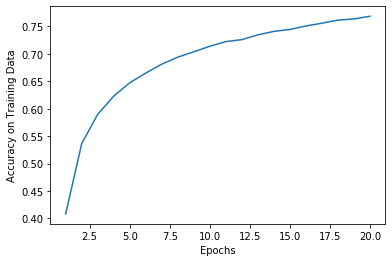

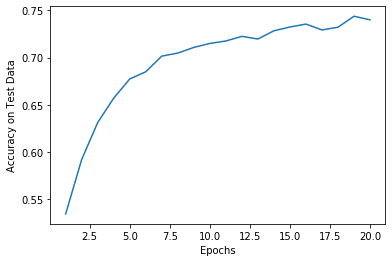

In [14]:
epoch_number = 20
train_acc = []
test_acc = []
for a in range (epoch_number):
    train_acc.append(train(batch_size = 128))
    test_acc.append(test())
print("final train acc : ")
print(train_acc[-1])
print("final test_acc : ")
print(test_acc[-1])
k = np.linspace(1,epoch_number,epoch_number)

plt.plot(k,train_acc) #plot train and test accuracy graphs
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Training Data")
plt.show()

plt.plot(k,test_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Test Data")
plt.show()

## Close the session

In [0]:
session.close()

## Discussion

In this part of the 3rd question the network given in the figure is implemented using the 'high' level API
functions. Inputs are divided by 255 in order to place the numbers between 0-1. Dividing by 255 was rooted from the fact that inputs are
pixel values of images. System consists of total a total of 3 convolution layers, 3 pooling layers each are placed after
a convolution layer. After the third pooling layer 2 fully connected layers are present. Fully connected
layers have 128 and 10 neurons respectively. Outside the network, a softmax activation function completes the 
network's guess for each image. Input size is not changed in conv. layers but downsampled to half of the input'size
size in each pooling layers. 

In network definition, pooling type is not specified, AVG pooling is choosen in order to
reduce information loss between layers. In max pooling final train_acc,test_acc = [0.71, 0.71],  while the
final train_acc, test_acc = [0.72, 0.72] in average pooling, after 10 epochs. Here and later "computation time"
refers to neither training, nor test time but a mixture of them. Time is calculated the execution duration of the 14th cell
given by Google CoLab when mouse is hovered on the 'play' button, hw accelerator is choosen as GPU. Computation time of each 
option resulted around 65 seconds.

However, both of the implementations' lower API versions resulted in a shorter computation duration of
50 seconds. This is due to fact that lower level API gives more work for the programmer but it is purified from the overheads of
high-level functions. In general, it can be said that, lower level API can result in faster implementation.

Another unspecified point was the batch size, with batch_size 128, computation time for 10 epochs is ~65secs. and 
final test acc. is aroung 72%. When batch_size is reduced to 32, computation time for 10 epochs increased to 120 secs. while
final test acc. increased to 73%. One reason of the accuracy increase [1] can be the fact that smaller batch sizes are noisy, 
offering a regularizing effect and lower generalization error.

Dropout is implemented by using different dropout rates for test and training feed_dict's. Original dropout rates are 
0.4 and 0.01 for train and test respectively. When dropout is set to 0.99 for each function,test accuracy decreased to 0.1
network doesn't learn anything during training and 1st fully connected layer neurons are not working, guess is completely randomized by output neurons.
Later dropout is set to 0.99 and 0.01 for training and test respectively final test result was again 0.1. This time neurons were on for inference but,
they were off while training hence, no learning observed. Turning off the neurons (dropout = 0.99 in both) did not changed the computation time.

When epoch number is increased to 20 from 10, final test accuracy also increased to 76%.Moreover, computation time is also 
increased to 120 secs.

When we bypass the batch_normalization, final test accuracy drop to 66% from 76% in 20 epochs. Moreover, computation
time is decreased to 110 seconds since network's computation cost is decreased.

[1] https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

## References

[1] [Arm Community](https://community.arm.com)

[2] https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

[3] https://gist.github.com/andrewkruger/d62faac06f950c4388d9b23aae0c9cc9#file-gistfile1-txt

[4] https://github.com/METU-MMI-DeepLearning/MMI713_Deep_Learning/blob/master/Lab1.ipynb